In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
#Computer vision libraries
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor


In [4]:
train_data = datasets.FashionMNIST(
    root='data',
    train= True,
    download = True,
    transform = ToTensor(),
    target_transform =None
)
test_data = datasets.FashionMNIST(
    root='data',
    train= False,
    download = True,
    transform = ToTensor(),
    target_transform =None
)

In [5]:
class_names = train_data.classes

In [6]:

train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

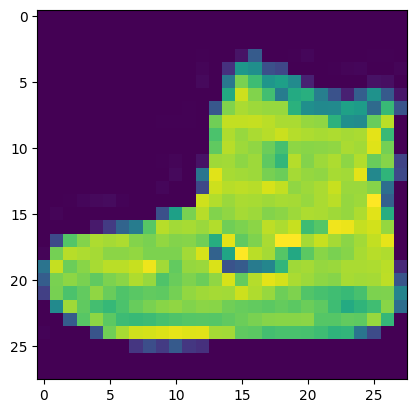

In [8]:
# image format is in NCHW
image,label = train_data[0]
plt.imshow(image.squeeze())

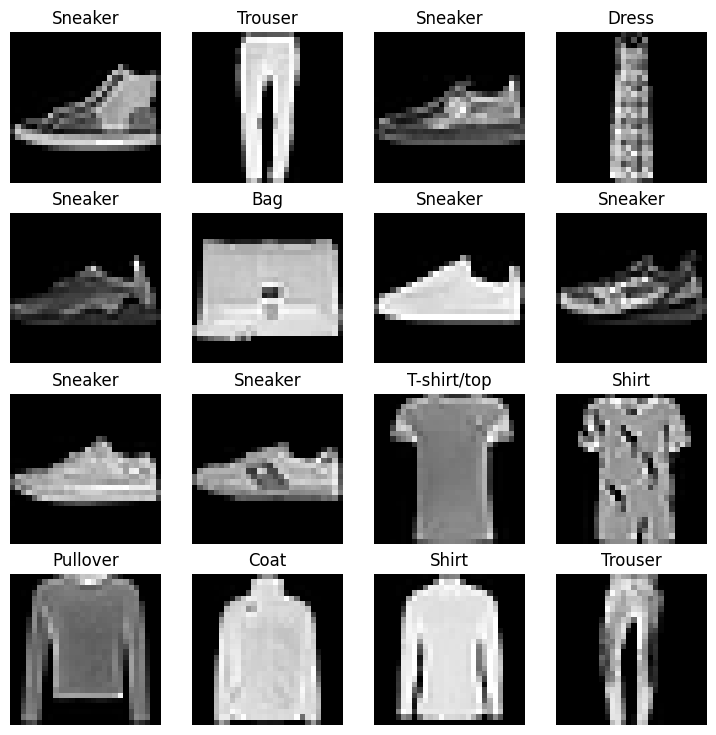

In [9]:

fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [72]:
#DataLoader turns a dataset into python iterables
# Default batch size is 32
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)

test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x20f6a665610>,
 <torch.utils.data.dataloader.DataLoader at 0x20f0a763e90>)

In [73]:
len(train_dataloader),len(test_dataloader)

(1875, 313)

In [74]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

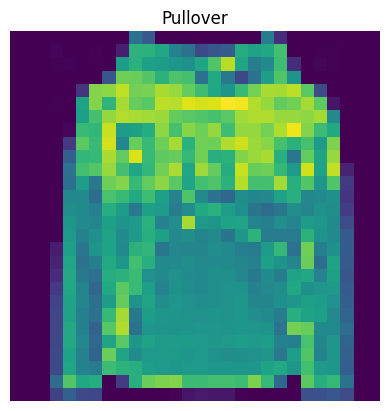

In [75]:
# torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze())
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [76]:
#Creating a flatten layer
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)
print(output.squeeze())

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3098, 0.4000, 0.3843, 0.3686, 0.1059,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0235, 0.0000, 0.5569, 0.4588, 0.0471, 0.0314, 0.1216,
        0.5059, 0.2784, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3843, 0.4745, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.4667, 0.2118, 0.0000, 0.0078, 0.0078, 0.0000, 0.0078,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [88]:
class FashionMnist(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int,):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.ReLU()
        )
    def forward(self,x):
        return self.layer_stack(x)

In [89]:
model0 = FashionMnist(input_shape=784,hidden_units=10,output_shape=len(class_names)).to(device)


In [90]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(params=model0.parameters(),lr =lr)

In [91]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
def print_train_time(start:float,end:float,device:torch.device=None):
    total_time = end - start
    print(f"Train time on {device} : {total_time: .3f} seconds")
    return(total_time)

In [94]:
def train_step(model,train_dataloader,loss_fn,optimizer):
    train_loss = 0
    model.train()
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device),y.to(device)
        y_logits = model(X)
        loss = loss_fn(y_logits,y)
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    print(f"Train loss: {train_loss}")

In [97]:
def test_step(model,test_dataloader,loss_fn):
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            X,y = X.to(device),y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred,y)
            test_loss += loss
        test_loss/=len(test_dataloader)
    print(f"Test loss: {test_loss}")

In [98]:
epochs = 3

start = timer()


for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}\n----")
    train_step(model0,train_dataloader,loss_fn,optimizer)
    test_step(model0,test_dataloader,loss_fn)
    
    
end = timer()
print_train_time(start,end,'cpu')

        

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
----
Train loss: 1.1440256834030151


 33%|███▎      | 1/3 [00:11<00:22, 11.41s/it]

Test loss: 1.2380534410476685
Epoch : 1
----
Train loss: 1.1018136739730835


 67%|██████▋   | 2/3 [00:22<00:11, 11.41s/it]

Test loss: 0.9574037790298462
Epoch : 2
----
Train loss: 0.9046028852462769


100%|██████████| 3/3 [00:34<00:00, 11.34s/it]

Test loss: 0.9173563122749329
Train time on cpu :  34.020 seconds


34.019902600033674

In [101]:
def eval_model(model: torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn: torch.nn.Module):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred,y)
        loss /= len(data_loader)
        return ({"model_name":model.__class__.__name__,"model_loss ":loss})

In [102]:
model0_results = eval_model(model0,test_dataloader,loss_fn)
print(model0_results)

{'model_name': 'FashionMnist', 'model_loss ': tensor(0.9174, device='cuda:0')}
